Google Drive Authentication
---

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

%cd /gdrive/My Drive/IIC/

Mounted at /gdrive
/gdrive/My Drive/DrRabiee-Project


Importing/Installing the Necessary Libraries
---

In [ ]:
pip install torch===1.0.0 torchvision===0.2.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 591.8MB 27kB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.0.0 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102


In [ ]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 104kB/s 
ERROR: pymc3 3.11.2 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
!pip3 install pyro-ppl==0.2.1

     |████████████████████████████████| 112kB 29.7MB/s 
  Created wheel for pyro-ppl: filename=pyro_ppl-0.2.1-cp37-none-any.whl size=159537 sha256=3edfe108d2dc4cbf57708583a56f0c4a84fe6d97a6268db8ed52860debdbc440
  Stored in directory: /root/.cache/pip/wheels/2b/07/a8/a99cd69d0221c35285eb6cfe727d2316dcd59fbcb8f7ed797e
Successfully built pyro-ppl


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread

In [ ]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [ ]:
from skimage.color import gray2rgb
from skimage.color import rgb2gray

In [ ]:
%matplotlib inline

In [ ]:
import bottleneck as bn
from sklearn.metrics import accuracy_score

In [ ]:
import tensorflow as tf

In [ ]:
pip install shap

     |████████████████████████████████| 358kB 25.7MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491632 sha256=3937dd15f66498fc8a8f78ab6ce12abde008e58f30b6728d1fdc110e8d2da7e7
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
import shap

In [ ]:
from skimage.segmentation import slic
from matplotlib.colors import LinearSegmentedColormap

Loading MNIST Data
---

In [ ]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

Defining the Model Architecture
---

In [ ]:
class NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

In [ ]:
net = NN(28*28, 1024, 10)

In [ ]:
log_softmax = nn.LogSoftmax(dim=1)

In [ ]:
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [ ]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

Training the Model
---

In [ ]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [ ]:
num_iterations = 5
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

Epoch  0  Loss  2062.4058182778517
Epoch  1  Loss  356.499234710598
Epoch  2  Loss  154.20010705167454
Epoch  3  Loss  110.11890512959162
Epoch  4  Loss  96.21912669062614


Calculating the Prediction Accuracy in the Normal Way (forced to predict something)
---

In [ ]:
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    #return np.argmax(mean.numpy(), axis=1)
    return torch.argmax(mean, dim=1)


print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,28*28))
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 88 %


In [ ]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [ ]:
num_samples = 100
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    x = torch.Tensor(x)
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)
    #mean = torch.mean(torch.stack(yhats), 0)
    #return np.argmax(mean, axis=1)

In [ ]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images if predicted_for_images!=0 else 0)
        
    return len(labels), correct_predictions, predicted_for_images 
    

In [ ]:
temp_data = []
for batch_id, data in enumerate(test_loader):
    if batch_id == 0:
        temp_data = data
    else:
        continue

In [ ]:
temp_data[0].shape

torch.Size([128, 1, 28, 28])

In [ ]:
x_test = temp_data[0][:100]

In [ ]:
x_test.shape

torch.Size([100, 1, 28, 28])

In [ ]:
y_test = temp_data[1][:100]

In [ ]:
y_test.shape

torch.Size([100])

SHAP tries
---

In [ ]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

In [ ]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out

In [ ]:
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

In [ ]:
feature_names = {'0':['n1','0'], '1':['n2','1'], '2':['n3','2'], '3':['n4','3'], '4':['n5','4'], '5':['n6','5'], '6':['n7','6'], '7':['n8','7'], '8':['n9','8'], '9':['n10','9']}

In [ ]:
def cifar_to_pil(img):
    img = img*255
    PIL_image = Image.fromarray(np.uint8(img)).convert('RGB')
    return PIL_image

In [ ]:
def get_shap_values(img_orig, model, num_segments=50):
    def f(z):
        return predict(mask_image(z, segments_slic, img_orig, 255))

    img = cifar_to_pil(img_orig)
    segments_slic = slic(img, n_segments=num_segments, compactness=30, sigma=3)
    explainer = shap.KernelExplainer(f, np.zeros((1,num_segments)))
    shap_values = explainer.shap_values(np.ones((1,num_segments)), nsamples=1000)
    preds = model.predict(np.expand_dims(img_orig.copy(), axis=0))
    top_preds = np.argsort(-preds)
    return img, segments_slic, shap_values, top_preds

In [ ]:
def new_inner_predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    #return np.argmax(mean.numpy(), axis=1)
    return mean

In [ ]:
def inner_predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    #return np.argmax(mean.numpy(), axis=1)
    return mean

In [ ]:
def new_predict(x):
    x = rgb2gray(x)
    x = torch.Tensor(x)
    x = x.view(-1,28*28)
    return inner_predict(x).numpy()

In [ ]:
def get_shap_values(input_img, model, num_segments=50):
    img_orig = gray2rgb(input_img.squeeze().numpy())

    def f(z):
        return new_predict(mask_image(z, segments_slic, img_orig, 255))

    img = cifar_to_pil(gray2rgb(input_img.squeeze().numpy()))
    segments_slic = slic(img, n_segments=num_segments, compactness=30, sigma=3)
    explainer = shap.KernelExplainer(f, np.zeros((1,num_segments)))
    shap_values = explainer.shap_values(np.ones((1,num_segments)), nsamples=1000)
    preds = new_predict(np.expand_dims(img_orig.copy(), axis=0))
    top_preds = np.argsort(-preds)
    return img, segments_slic, shap_values, top_preds

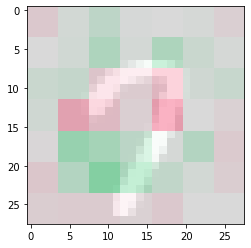

In [ ]:
img_orig = temp_data[0][0]
img, segments_slic, shap_values, top_preds = get_shap_values(img_orig, model)
num_top_pred = 0
m = fill_segmentation(shap_values[top_preds[0][num_top_pred]][0], segments_slic)
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
plt.imshow(img.convert('LA'), alpha=0.15)
plt.imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)

In [ ]:
def get_heatmap(input_img, model):
    img_orig = input_img
    img, segments_slic, shap_values, top_preds = get_shap_values(img_orig, model)
    max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
    num_top_pred = 0
    heatmap = fill_segmentation(shap_values[top_preds[0][num_top_pred]][0], segments_slic)
    return heatmap

In [ ]:
# the following function gets the top n elements (in terms of magnitude) from a numpy array
def top_n_indexes(arr, n):
    idx = bn.argpartition(arr, arr.size-n, axis=None)[-n:]
    width = arr.shape[1]
    return [divmod(i, width) for i in idx]

In [ ]:
# given a list of tuples (pixel indices), this function generates a list of other pixels
def get_other_pixels(idx_list):
    idx_list = set(idx_list)
    other_pixels = []
    for i in range(28):
        for j in range(28):
            if (i,j) not in idx_list:
                other_pixels.append((i,j))
    return other_pixels

In [ ]:
# given an image and a heatmap showing the importance of each pixels, this function destructs the image such that only a specified percentage of
# the most important pixels remains, and the other ones get replaced by salt and pepper noise
def destruct_image(img, heatmap, percentage=0.2):
    result = img.numpy().squeeze().copy()
    idx_list = top_n_indexes(heatmap, int(percentage*(28*28)))
    idx_list.sort(key = lambda tup: tup[0])
    other_pixels = get_other_pixels(idx_list)
    for idx in other_pixels:
        # random_val = random.sample([0,1], 1)[0]
        random_val = 0
        result[idx[0],idx[1]] = random_val
    return result

In [ ]:
temp_data[0].shape

torch.Size([16, 1, 28, 28])

In [ ]:
x_test.shape

torch.Size([100, 1, 28, 28])

Measuring the impact of adding pepper noise on the accuracy of the model on the test data, and observing how the confidence scores generated by the model degrade through this procedure
---

In [ ]:
new_x_test = []
for curr_img in x_test[:100]:
    curr_heatmap = get_heatmap(curr_img, model)
    new_img = destruct_image(curr_img, curr_heatmap, 0.2)
    new_x_test.append(new_img)
new_x_test = np.array(new_x_test)

In [ ]:
new_x_test.shape

(100, 28, 28)

In [ ]:
predictions = list(predict(torch.Tensor(new_x_test).view(-1,28*28)))

In [ ]:
y_test = list(y_test)

In [ ]:
accuracy_score(y_test, predictions)

0.01

In [ ]:
new_x_test = []
for curr_img in x_test[:100]:
    curr_heatmap = get_heatmap(curr_img, model)
    new_img = destruct_image(curr_img, curr_heatmap, 0.1)
    new_x_test.append(new_img)
new_x_test = np.array(new_x_test)

predictions = list(predict(torch.Tensor(new_x_test).view(-1,28*28)))

y_test = list(y_test)

accuracy_score(y_test, predictions)

0.05

In [ ]:
new_x_test = []
for curr_img in x_test[:100]:
    curr_heatmap = get_heatmap(curr_img, model)
    new_img = destruct_image(curr_img, curr_heatmap, 0.3)
    new_x_test.append(new_img)
new_x_test = np.array(new_x_test)

predictions = list(predict(torch.Tensor(new_x_test).view(-1,28*28)))

y_test = list(y_test)

accuracy_score(y_test, predictions)

0.03

In [ ]:
new_x_test = []
for curr_img in x_test[:100]:
    curr_heatmap = get_heatmap(curr_img, model)
    new_img = destruct_image(curr_img, curr_heatmap, 0.4)
    new_x_test.append(new_img)
new_x_test = np.array(new_x_test)

predictions = list(predict(torch.Tensor(new_x_test).view(-1,28*28)))

y_test = list(y_test)

accuracy_score(y_test, predictions)

0.05

In [ ]:
new_x_test = []
for curr_img in x_test[:100]:
    curr_heatmap = get_heatmap(curr_img, model)
    new_img = destruct_image(curr_img, curr_heatmap, 0.5)
    new_x_test.append(new_img)
new_x_test = np.array(new_x_test)

predictions = list(predict(torch.Tensor(new_x_test).view(-1,28*28)))

y_test = list(y_test)

accuracy_score(y_test, predictions)

0.11

Mean Confidence Scores

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [ ]:
new_x_test = []
for curr_img in x_test[:100]:
    curr_heatmap = get_heatmap(curr_img, model)
    new_img = destruct_image(curr_img, curr_heatmap, 0.1)
    new_x_test.append(new_img)
new_x_test = np.array(new_x_test)

predictions = list(inner_predict(torch.Tensor(new_x_test).view(-1,28*28)))

max_elements = [max(list(softmax(prediction.numpy()))) for prediction in predictions]

curr_min = min(max_elements)
curr_max = max(max_elements)
curr_mean = sum(max_elements)/len(max_elements)

print(f'Min Confidence: {curr_min}, Max Confidence: {curr_max}, Average: {curr_mean}')


Min Confidence: 0.5029220581054688, Max Confidence: 1.0, Average: 0.9533005303144455


In [ ]:
new_x_test = []
for curr_img in x_test[:100]:
    curr_heatmap = get_heatmap(curr_img, model)
    new_img = destruct_image(curr_img, curr_heatmap, 0.2)
    new_x_test.append(new_img)
new_x_test = np.array(new_x_test)

predictions = list(inner_predict(torch.Tensor(new_x_test).view(-1,28*28)))

max_elements = [max(list(softmax(prediction.numpy()))) for prediction in predictions]

curr_min = min(max_elements)
curr_max = max(max_elements)
curr_mean = sum(max_elements)/len(max_elements)

print(f'Min Confidence: {curr_min}, Max Confidence: {curr_max}, Average: {curr_mean}')


Min Confidence: 0.5824984312057495, Max Confidence: 1.0, Average: 0.9770224821567536


In [ ]:
new_x_test = []
for curr_img in x_test[:100]:
    curr_heatmap = get_heatmap(curr_img, model)
    new_img = destruct_image(curr_img, curr_heatmap, 0.3)
    new_x_test.append(new_img)
new_x_test = np.array(new_x_test)

predictions = list(inner_predict(torch.Tensor(new_x_test).view(-1,28*28)))

max_elements = [max(list(softmax(prediction.numpy()))) for prediction in predictions]

curr_min = min(max_elements)
curr_max = max(max_elements)
curr_mean = sum(max_elements)/len(max_elements)

print(f'Min Confidence: {curr_min}, Max Confidence: {curr_max}, Average: {curr_mean}')


Min Confidence: 0.5783177614212036, Max Confidence: 1.0, Average: 0.9916847610473633


In [ ]:
new_x_test = []
for curr_img in x_test[:100]:
    curr_heatmap = get_heatmap(curr_img, model)
    new_img = destruct_image(curr_img, curr_heatmap, 0.4)
    new_x_test.append(new_img)
new_x_test = np.array(new_x_test)

predictions = list(inner_predict(torch.Tensor(new_x_test).view(-1,28*28)))

max_elements = [max(list(softmax(prediction.numpy()))) for prediction in predictions]

curr_min = min(max_elements)
curr_max = max(max_elements)
curr_mean = sum(max_elements)/len(max_elements)

print(f'Min Confidence: {curr_min}, Max Confidence: {curr_max}, Average: {curr_mean}')


Min Confidence: 0.5193276405334473, Max Confidence: 1.0, Average: 0.9801049536466598


In [ ]:
new_x_test = []
for curr_img in x_test[:100]:
    curr_heatmap = get_heatmap(curr_img, model)
    new_img = destruct_image(curr_img, curr_heatmap, 0.5)
    new_x_test.append(new_img)
new_x_test = np.array(new_x_test)

predictions = list(inner_predict(torch.Tensor(new_x_test).view(-1,28*28)))

max_elements = [max(list(softmax(prediction.numpy()))) for prediction in predictions]

curr_min = min(max_elements)
curr_max = max(max_elements)
curr_mean = sum(max_elements)/len(max_elements)

print(f'Min Confidence: {curr_min}, Max Confidence: {curr_max}, Average: {curr_mean}')


Min Confidence: 0.516658365726471, Max Confidence: 1.0, Average: 0.9770688581466674
